# **Pharmacovigilance Project**

> The aim of the project is to auto-identify Adverse Drug Reactions (ADR) from Electronic Health Records (EHR). <br>
> This notebook walk you through the steps on using Transfer Learning on Natural Language Processing to accomplish this task.





## Install packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install -qq transformers

### Import packages

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import re
import requests
import numpy as np
import pandas as pd
import seaborn as sns
from io import StringIO
from textwrap import wrap
from matplotlib import rc
from pylab import rcParams
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

import torch
import transformers
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

### Set notebook parameters

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='svg'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#4177ea", "#531dc6", "#0f7026", "#a11caf", "#237508"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 10, 6
RANDOM_SEED = 128
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Load data

In [ ]:
# MIMIC dataset
def load_data(path):
  """Function to load data from excel file
  Args:
    path (str) : path to the excel file

  Returns:
    pandas.DataFrame: Data in pandas dataframe format

  """
  return pd.read_excel(path)

path = "/content/drive/My Drive/ADR/data/data_upsampled.xlsx"
df = load_data(path=path)

In [ ]:
def remove_cols(df, cols):
  """Function to remove columns from a DataFrame
  Args:
    df (pandas.DataFrame): Data in pandas dataframe format
    cols (list): List of column names to be removed
    
  Returns:
    pandas.DataFrame: Cleaned data in pandas dataframe format
  """
  return df.drop(cols, inplace=False, axis=1)

cols = ["Number","Unnamed: 0"]
df = remove_cols(df=df, cols=cols)
df.head()

,text,label
0,social work note:new trauma patient t-sicu. pa...,0
1,"ccu npn 1900-0700s:""who says i'm hospital?"" ""m...",0
2,nursing progress note:patient alert oriented x...,0
3,resp: patient remains a/c 18/550/+5/50%. bs co...,0
4,resp: simv 16/600/+5/10/40%. alarms functionin...,0


## Preprocessing the Dataset
We'll preprocess out texts to remove puctuations and special characters.

In [ ]:
def preprocess_text(text):
    # remove punctuations and numbers
    text = re.sub('[^a-zA-Z]', ' ', str(text))
    # remove single character
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    # removing multiple spaces
    text = re.sub(r'\s+', ' ', text)
    return text

In [ ]:
df.text = df.text.apply(preprocess_text)
df.text[0:5]

0    social work note new trauma patient sicu patie...
1    ccu npn who says m hospital my heart fine m su...
2    nursing progress note patient alert oriented n...
3    resp patient remains c bs coarse clear suction...
4    resp simv alarms functioning ambu syearinge ho...
Name: text, dtype: object

## Data splitting
Splitting data into Train, Validation and Test sets, 80% of the data will be used for training.

In [ ]:
df_train, tra_val  = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_valid, df_test  = train_test_split(tra_val, test_size=0.4, random_state=RANDOM_SEED)

### Creating Baseline model using Tf-idf
The goal of TF-IDF is to reduce the impact of the tokens that occur frequently in a given document, of which might be less informative than other token on that document. It evaluate how relevant a token is to a document in a collection of documents. 

In [ ]:
x_train, y_train = df_train.text.values, df_train.label.values.astype('int')
x_valid, y_valid = df_valid.text.values, df_valid.label.values.astype('int')
x_test, y_test = df_test.text.values, df_test.label.values.astype('int')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

In [ ]:
tf_idf = TfidfVectorizer(max_features=150) #max features a TFIDF can take 
x_train = np.r_[x_train, x_valid]
y_train = np.r_[y_train, y_valid]
x_train_tfidf = tf_idf.fit_transform(x_train).toarray()
# x_valid_tfidf = tf_idf.fit_transform(x_valid).toarray()
x_test_tfidf  = tf_idf.fit_transform(x_test).toarray()

**TF-IDF vocabulary from our dataset**

In [ ]:
tf_idf.vocabulary_.items()

dict_items([('patient', 90), ('remains', 105), ('noted', 85), ('ectopy', 41), ('note', 84), ('pulses', 99), ('edema', 42), ('time', 136), ('hct', 59), ('ordered', 88), ('tylenol', 142), ('given', 54), ('adverse', 4), ('reaction', 102), ('aware', 12), ('continue', 32), ('gtt', 57), ('monitor', 80), ('back', 13), ('good', 56), ('resp', 106), ('changes', 27), ('ccu', 26), ('nursing', 87), ('progress', 97), ('head', 60), ('pain', 89), ('see', 116), ('iv', 67), ('received', 104), ('right', 108), ('fentanyl', 47), ('hr', 62), ('neuro', 82), ('ett', 44), ('shift', 117), ('care', 22), ('today', 137), ('left', 69), ('intubated', 66), ('cc', 25), ('peep', 91), ('vent', 144), ('sats', 112), ('lungs', 71), ('coarse', 29), ('bs', 21), ('small', 120), ('secretions', 114), ('cv', 36), ('bp', 20), ('id', 64), ('max', 73), ('started', 126), ('gu', 58), ('foley', 49), ('access', 2), ('blood', 19), ('site', 118), ('skin', 119), ('mm', 78), ('per', 92), ('team', 133), ('am', 7), ('follow', 50), ('temp', 1

**Inverse Document Frequency**   <br>
IDF shows how common or rare a token is in a dataset. The closer it is to zero, the more common a token is.

In [ ]:
idf = tf_idf.idf_
print(dict(zip(tf_idf.get_feature_names(), idf)))

{'abd': 2.680896876416245, 'abg': 2.0647107369924282, 'access': 3.4117843849590375, 'administered': 2.2631616757162667, 'adverse': 1.8023464725249374, 'alarms': 3.0863619845244097, 'alb': 2.680896876416245, 'am': 2.9322113046971516, 'ambu': 3.032294763254134, 'amounts': 2.542746537935428, 'atr': 2.8856912890622586, 'auscultated': 3.337676412805316, 'aware': 3.204145020180793, 'back': 2.7186372043990925, 'bases': 3.268683541318364, 'bed': 3.4117843849590375, 'bilat': 4.030823593365261, 'bilateral': 3.204145020180793, 'bilaterally': 2.9322113046971516, 'blood': 3.4918270926325743, 'bp': 3.204145020180793, 'bs': 1.8658598782472633, 'care': 3.1435203983643585, 'carevue': 3.4117843849590375, 'cath': 3.779509165084355, 'cc': 2.798679912072629, 'ccu': 3.337676412805316, 'changes': 2.1265861407105158, 'clear': 2.2390641241372062, 'coarse': 2.421385680931161, 'commands': 3.337676412805316, 'cont': 3.268683541318364, 'continue': 2.0064418288684527, 'continues': 3.268683541318364, 'cough': 3.4117

**Visualizing IDF** 

In [ ]:
d = dict(zip(tf_idf.get_feature_names(), idf))
token_weight = pd.DataFrame.from_dict(d, orient='index').reset_index()
token_weight.columns=('token','weight')
# sort token weights in ascending order
token_weight = token_weight.sort_values(by='weight', ascending=True).head(15)

Barplot showing idf againt tokens

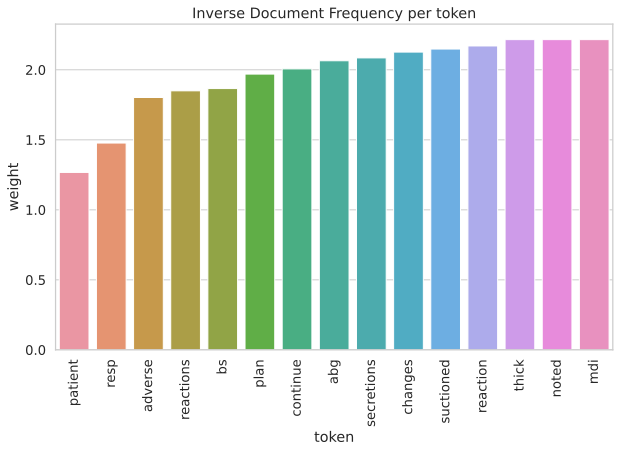

In [ ]:
sns.barplot(x='token', y='weight', data=token_weight)            
plt.title("Inverse Document Frequency per token")
plt.xticks(rotation=90)
plt.show()

In [ ]:
token_weight

,token,weight
90,patient,1.267204
106,resp,1.476924
4,adverse,1.802346
103,reactions,1.849599
21,bs,1.865860
94,plan,1.969401
32,continue,2.006442
1,abg,2.064711
114,secretions,2.084913
27,changes,2.126586


TF-IDF for the first training row `x_train[0]`

In [ ]:
print(x_train[0])

ccu nursing progress note pneuro patient alert oriented cooperative care moving around independently bed waist restraint removed patient made attempatients getting oob resp ls bibasialr rales resolved lasix weaned nrb nc sats patient appears get slightly sob movement turning however patient denies feeling sob winded states feels so much better today last night rec mg iv lasix great response patient evening cardiac sbp hr vent trigeminy patient denies cardiac complaints lopressor restarted given mild hypotension gi tolerating cardiac diet abd soft nt bs stool shift hct stable s bleeding gu lasix labs stable skin rash much improved trunk legs notable back patient denies itchiness benadryl dc acute anaphylaxis reaction resolved likely t allergy plavix given patient similar reaction motrin past similar derivatives plavix steroid taper progress well plavix dc patient started po ticlid without side effects noted s anaphylactic reaction palvix hemodynamically stable today assess resp status d

In [ ]:
df_train_tdif = pd.DataFrame(x_train_tfidf[0].T, index=tf_idf.get_feature_names(), columns=["tfidf"])
df_train_tdif.sort_values(by=["tfidf"], ascending=False).head(10)

,tfidf
patient,0.424117
stable,0.373223
received,0.273377
pulses,0.227286
today,0.210491
goal,0.194972
reaction,0.141751
wean,0.136032
lip,0.135157
progress,0.134869


In [ ]:
models = []
models.append(('LR', LogisticRegression(max_iter=5)))
models.append(('KNN',KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier(n_estimators=3)))
models.append(('SVC', SVC(gamma='scale')))
models.append(('GB',  GradientBoostingClassifier()))
models.append(('MNB', MultinomialNB()))

In [ ]:
names = []
scores = []

for name, model in models:
    model.fit(x_train_tfidf, y_train)
    y_pred = model.predict(x_test_tfidf)
    scores.append(f'{accuracy_score(y_test, y_pred)*100:.1f}')
    names.append(name)

pd.DataFrame({'Classification Algorithm': names, 'Accuracy(%)': scores})

,Classification Algorithm,Accuracy(%)
0,LR,70.1
1,KNN,52.1
2,DT,62.5
3,RF,63.2
4,SVC,65.3
5,GB,77.8
6,MNB,76.4


### Training and evaluating Multinomial Naive Bayes Classifier

In [ ]:
classifier = MultinomialNB()
classifier.fit(x_train_tfidf, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Making prediction on test set

In [ ]:
preds = classifier.predict(x_test_tfidf)

### Evaluating `MultinomialNB`


> 
\begin{align}
Accuracy = \frac{Correct Predictions}{TotalPredictions}
\end{align}

<br>

**f1-score** is the Harmonic Mean between Precision and Recall. It tries to find the balance between precision and recall.
\begin{align}
f1-score = 2 \times \frac{1}{\frac{1}{precision} + \frac{1}{recall} }
\end{align}

<br>

**Precision** is the number of correct positive results divided by the number of positive results predicted by the classifier
\begin{align}
Precision = \frac{TruePositives}{ TruePositives + FalsePositives}
\end{align}

<br>

**Recall** is the number of correct positive results divided by the number of all relevant samples (all samples that should have been identified as positive).
\begin{align}
Precision = \frac{TruePositives}{ TruePositives + FalseNegatives}
\end{align}
> 


In [ ]:
print(f'Accuracy:  {accuracy_score(y_test, preds)*100:.0f}%')
print(f'f1-score:  {f1_score(y_test, preds)*100:.1f}')
print(f'Precision: {precision_score(y_test, preds)*100:.1f}')
print(f'Recall:    {recall_score(y_test, preds)*100:.1f}')

Accuracy:  76%
f1-score:  77.0
Precision: 75.0
Recall:    79.2


Classification report showing the summary of precision,recall and f1-score.

In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.78      0.74      0.76        72
           1       0.75      0.79      0.77        72

    accuracy                           0.76       144
   macro avg       0.76      0.76      0.76       144
weighted avg       0.76      0.76      0.76       144



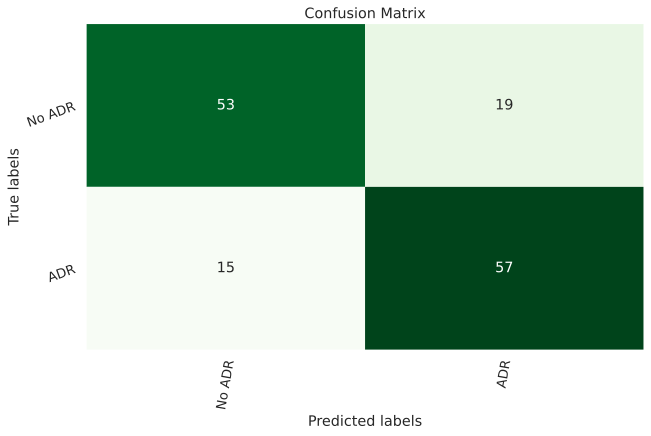

In [ ]:
class_map = {
    0: 'No ADR',
    1: 'ADR'
    }

def show_confusion_matrix(confusion_matrix):
    labels = list(class_map.values())
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Greens", cbar=False)
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels([''])+labels, rotation=20)
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels([''])+labels, rotation=80)
    plt.title('Confusion Matrix')
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels');

cm = confusion_matrix(y_test, preds)
show_confusion_matrix(cm)

### Cross-validation

In [ ]:
x, y = df.text, df.label.astype('int')
x = tf_idf.fit_transform(x).toarray()

In [ ]:
folds = StratifiedKFold(n_splits=10, random_state=RANDOM_SEED)

In [ ]:
names = []
scores = []
for name, model in models:
    score = cross_val_score(model, x, y, cv=folds, scoring='accuracy').mean()*100
    names.append(name)
    scores.append(f'{score:.1f}')

results = pd.DataFrame({'Classification Algorithm': names, 'Accuracy(%)': scores})
results

,Classification Algorithm,Accuracy(%)
0,LR,80.1
1,KNN,82.8
2,DT,90.6
3,RF,90.6
4,SVC,90.0
5,GB,87.5
6,MNB,79.7


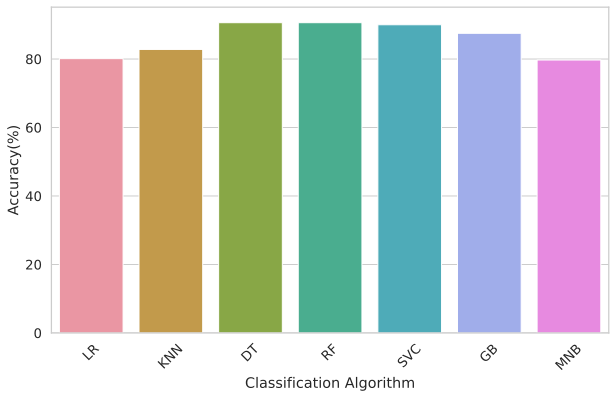

In [ ]:
axis = sns.barplot(x='Classification Algorithm', y='Accuracy(%)', data=results)
axis.set(xlabel='Classification Algorithm', ylabel='Accuracy(%)')
plt.xticks(rotation=45)
plt.show()

# Transfer Learning

## Tokenization
In order to user pre-trained BERT it's necessary to use Tokenizer provided by thie library for reasons:- <br>
- The model have specific, fixed vocabulary
- BERT tokenizer provide a way to handle out-of-vocabulary texts. <br>

**Tokenization involve the following:-**
<ol>
<li>Split text into tokens</li>
<li>Add special tokens `CLS` and `SEP`</li>
<li>Convert tokens into indexes</li>
<li>Pad or truncate text to maximum sequence length</li>
<li>Create attention masks</li>
</ol>

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
# Load Bert Tokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

## Choosing sequence length

In [ ]:
token_lens = []
for txt in df.text:
  tokens = tokenizer.encode(str(txt), max_length=512, truncation=True)swahili new
  token_lens.append(len(tokens))

### Show distribution of lengths for all texts in a dataset

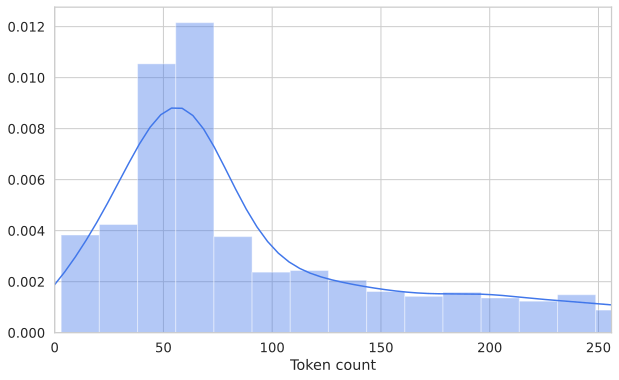

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);  #max lenght of the sequence
plt.xlabel('Token count');

Most of the tokens have sequence length less than 200

## Dataset

In [ ]:
MAX_LEN = 250

In [ ]:
class MimicDataset(Dataset):
  def __init__(self, text, targets, tokenizer, max_len):
    self.text = text
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, item):
    text = str(self.text[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      text = preprocess_text(text),
      add_special_tokens=True, # Add `[CLS]` and `[SEP]`
      max_length=self.max_len, # Define maximum sequence length
      truncation=True,         # Truncate on maximum seq length
      return_token_type_ids=False,  
      pad_to_max_length=True,  # Pad seq to Max length
      return_attention_mask=True,  # Return attenstion mask
      return_tensors='pt',    # Return pytorch tensor
    )
    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
# Utility function to create an iterator for our dataset
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = MimicDataset(text=df.text.to_numpy(), targets=df.label.to_numpy(),tokenizer=tokenizer,max_len=max_len)
  return DataLoader(ds, batch_size=batch_size, num_workers=4)

In [ ]:
BATCH_SIZE = 16
# Create dataloaders to help with saving memory and increasing training speed
# Dataloader for training set
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)

# Dataloader for validation set
valid_data_loader = create_data_loader(df_valid, tokenizer, MAX_LEN, BATCH_SIZE)

# Dataloader for test set
test_data_loader  = create_data_loader(df_test,  tokenizer, MAX_LEN, BATCH_SIZE)

## Pre-trained model

In [ ]:
# Load pre-trained BERT model
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

## MIMIC Classifier
To classify our texts into `ADR` or `Non-ADR` case using BERT, we added a classifier on top of BERT model trained on Language Modeling. <br>
This classifier consist of `Dropout Layer` and `Linear layer` which take the final transformer layer as a feature.

In [ ]:
class MimicClassifier(nn.Module):
  """
    Args:
      n_classes (int): Number of classes in the dataset
  """
  def __init__(self, n_classes=2, drop=0.45):
    super(MimicClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=drop)  # Droupout Layer of Classifier
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes) # Linear Layer of classifier

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    output = self.drop(pooled_output)  # Pass transformer output to Droupout Layer
    return self.out(output)

In [ ]:
model = MimicClassifier()
model = model.to(device)

## Training parameters
Here we define Optimizer and Learning Rate Scheduler. <br>
- Number of Epochs
- Learning Rate
- Loss function `nn.CrossEntropyLoss`

In [ ]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
loss_fn = nn.CrossEntropyLoss().to(device)

## Train function

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  # Set model into train mode
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    # model forward pass to return logits
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    _, preds = torch.max(outputs, dim=1)
    # calculate loss on the logits
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    # model backward pass to calculate gradients
    loss.backward()
    # clip gradient norm to 1.0 to avoid eploding gradient problem
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    # update model parameters
    optimizer.step()
    # update learning rate
    scheduler.step()
    # zero out previously calculated gradient
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

## Evaluation function
This evaluation function is more like train function except that model is set to eval mode and all `requires_grad` flags are set to `False`.

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  # Set model into evaluation mode
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      # get model predictions
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

## Train loop

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  
  train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
  print(f'Train loss {train_loss:.4f} accuracy {train_acc:.4f}')
  
  valid_acc, valid_loss = eval_model(model, valid_data_loader, loss_fn, device, len(df_valid))
  print(f'Valid loss {valid_loss:.4f} accuracy {valid_acc:.4f}')
  print()
  # accumulate train and validation loss and accuracy to vialualize model peformance
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['valid_acc'].append(valid_acc)
  history['valid_loss'].append(valid_loss)
  if valid_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = valid_acc

Epoch 1/5
----------
Train loss 0.5738 accuracy 0.7194
Valid loss 0.3981 accuracy 0.8611

Epoch 2/5
----------
Train loss 0.4708 accuracy 0.7938
Valid loss 0.3455 accuracy 0.8704

Epoch 3/5
----------
Train loss 0.3912 accuracy 0.8271
Valid loss 0.3225 accuracy 0.8889

Epoch 4/5
----------
Train loss 0.3115 accuracy 0.8521
Valid loss 0.3751 accuracy 0.8843

Epoch 5/5
----------
Train loss 0.2335 accuracy 0.8993
Valid loss 0.4110 accuracy 0.8981

CPU times: user 6min 7s, sys: 3min 37s, total: 9min 44s
Wall time: 9min 50s


## Accuracy evaluation plot

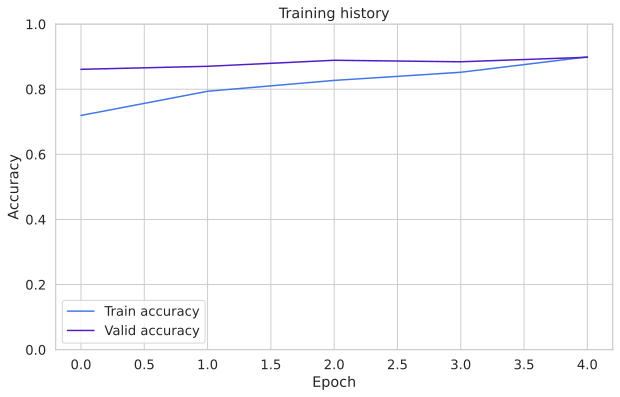

In [ ]:

plt.plot(history['train_acc'], label='Train accuracy')
plt.plot(history['valid_acc'], label='Valid accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## Loss evaluation plot

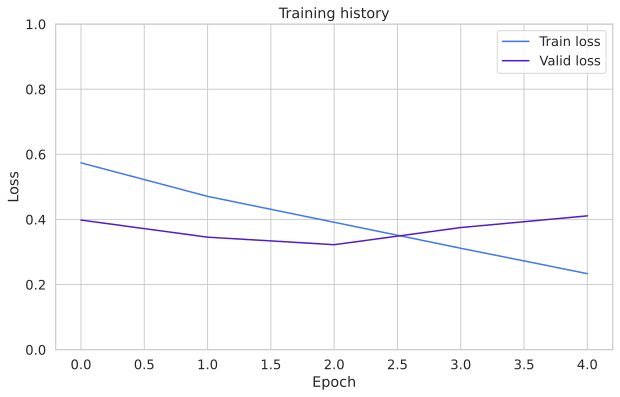

In [ ]:
plt.plot(history['train_loss'], label='Train loss')
plt.plot(history['valid_loss'], label='Valid loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## Evaluation

#### Evaluation accuracy on train data

In [ ]:
train_acc, _ = eval_model(model, train_data_loader, loss_fn, device, len(df_train))
print(f'Train accuracy: {train_acc.item():.3f}')

Train accuracy: 0.931


#### Ealuation accuracy on valid data

In [ ]:
valid_acc, _ = eval_model(model, valid_data_loader, loss_fn, device, len(df_valid))
print(f'Validation accuracy: {valid_acc.item():.3f}')

Validation accuracy: 0.898


#### Evaluation accuracy on test data

In [ ]:
test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))
print(f'Test accuracy: {test_acc.item():.3f}')

Test accuracy: 0.917


In [ ]:
# utility function for evaluating model perfomance
def get_predictions(model, data_loader):
  model = model.eval()
  text = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)
      text.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return text, predictions, prediction_probs, real_values

## Classification report

In [ ]:
y_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.90      0.92        72
           1       0.91      0.93      0.92        72

    accuracy                           0.92       144
   macro avg       0.92      0.92      0.92       144
weighted avg       0.92      0.92      0.92       144



## Confusion matrix


TN: 65
FP: 7
FN: 5
TP: 67



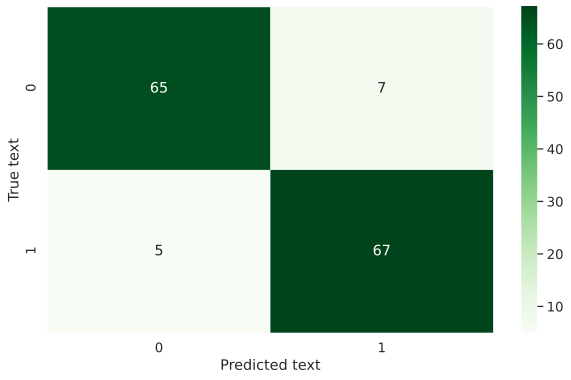

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Greens")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels())
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels())
  plt.ylabel('True text')
  plt.xlabel('Predicted text');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm)
tn, fp, fn, tp = cm.ravel()
print(f"""
TN: {tn}
FP: {fp}
FN: {fn}
TP: {tp}
""")
show_confusion_matrix(df_cm)

## Making prediction on input text

In [ ]:
# the same Classifier Class we used before
class MimicClassifier(nn.Module):
  def __init__(self, n_classes=2, drop=0.35):
    super(MimicClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=drop)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    output = self.drop(pooled_output)
    return self.out(output)

PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
loaded_model = MimicClassifier()
loaded_model.to(device)
# Loading model parameters from saved model file 'best_model_state.bin'
loaded_model.load_state_dict(torch.load('best_model_state.bin'))

<All keys matched successfully>

In [ ]:
def predict_text(text, model=loaded_model):
    # Define Tokenizer for encoding input text
    encode_text = tokenizer.encode_plus(
        text,
        max_length=160,
        truncation=True,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt')
    
    # Map model labels to text
    class_map = {
        0: 'No ADR',
        1: 'ADR'
    }
    # Define inputs to the model for making prediction
    input_ids = encode_text['input_ids'].to(device)
    attention_mask = encode_text['attention_mask'].to(device)

    # Make prediction using loaded model
    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    label = class_map[prediction.item()]
    return text, label   

In [ ]:
text = "social work note:new trauma patient t-sicu. patient 42 year old married man lives."
print(f'{predict_text(text)[1]}')

No ADR


In [ ]:
text = "respiratory carepatient remains trached (#7.0 portex) vent support. vent changes a/c psv patient spont breathing holding sats. lung sounds clear dim t/o. suctioned sm white thin secretions. mdis given adverse effects. abg drawn. care plan continue current therapy remain psv tol. continue follow patient."
print(f'{predict_text(text)[1]}')

No ADR


In [ ]:
! cp best_model_state.bin "/content/drive/My Drive/ADR/"